In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Исследование данных

#### Загрузка датасетов:

In [2]:
DATASET_PATH = 'train.csv'
PREPARED_DATASET_PATH = 'test.csv'

data=pd.read_csv(DATASET_PATH)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


Видим, что данные составляют 10000 записей, включают в себя типы int64, float64 и object. Часть признаков присутствует не полностью, в частности, LifeSquare (жилая площадь) и HealtCare_1 (показатель охраны здоровья)

In [15]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.891300,56.315775,35.538767,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.838185,21.058732,76.655938,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,29.339360,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


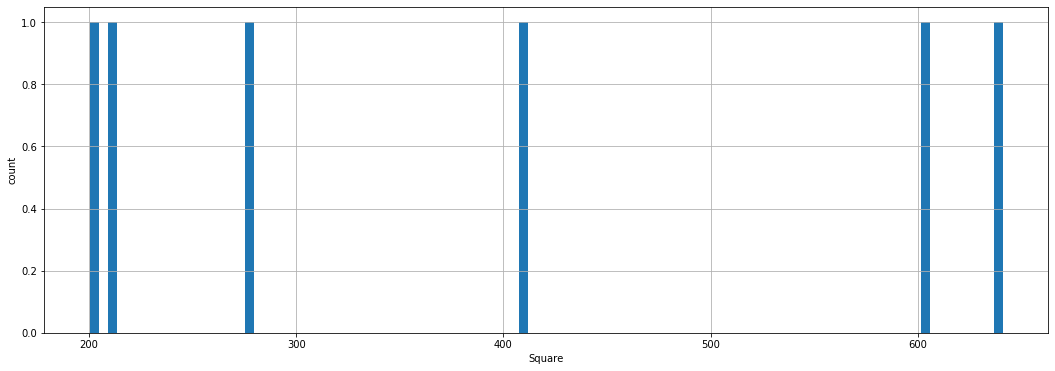

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 1981 to 9910
Data columns (total 20 columns):
Id               6 non-null int64
DistrictId       6 non-null int64
Rooms            6 non-null float64
Square           6 non-null float64
LifeSquare       5 non-null float64
KitchenSquare    6 non-null float64
Floor            6 non-null int64
HouseFloor       6 non-null float64
HouseYear        6 non-null int64
Ecology_1        6 non-null float64
Ecology_2        6 non-null object
Ecology_3        6 non-null object
Social_1         6 non-null int64
Social_2         6 non-null int64
Social_3         6 non-null int64
Healthcare_1     4 non-null float64
Helthcare_2      6 non-null int64
Shops_1          6 non-null int64
Shops_2          6 non-null object
Price            6 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1008.0+ bytes


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
9910,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016


In [6]:
X1=data[data['Square'] > 200]

plt.figure(figsize=(18,6))
#X[X['Square']>200].hist(bins=100)
X1['Square'].hist(bins = 100)
plt.ylabel('count')
plt.xlabel('Square')
plt.show()
X1.info()
X1.head(10)

In [7]:
X1 = X1[['Square','Price']]
X1.sort_values(by = ['Square'])

,Square,Price
9910,200.334539,528560.506016
1981,212.932361,302211.260887
1982,275.645284,455264.882666
4690,409.425181,90470.430830
4262,604.705972,187717.242538
6977,641.065193,133529.681562


In [8]:
data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [9]:
#заменим нулевые значения комнат на 1
data.loc[data['Rooms'] == 0, 'Rooms'] = 1

In [10]:
data['Rooms'].value_counts()

2.0     3880
1.0     3713
3.0     2235
4.0      150
5.0       18
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [11]:
data["LifeSquare"].fillna(0, inplace=True)
data[['Square','LifeSquare']]

,Square,LifeSquare
0,47.981561,29.442751
1,65.683640,40.049543
2,44.947953,29.197612
3,53.352981,52.731512
4,39.649192,23.776169
5,80.384479,46.683720
6,62.254114,37.160377
7,80.312926,0.000000
8,64.511437,0.000000
9,46.461409,18.915552


In [12]:
data.loc[data['LifeSquare'] == 0, 'LifeSquare'] = data['LifeSquare'].mean()
data[['Square','LifeSquare']]

,Square,LifeSquare
0,47.981561,29.442751
1,65.683640,40.049543
2,44.947953,29.197612
3,53.352981,52.731512
4,39.649192,23.776169
5,80.384479,46.683720
6,62.254114,37.160377
7,80.312926,29.339360
8,64.511437,29.339360
9,46.461409,18.915552


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

NameError: name 'X' is not defined